In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

np.random.seed(42)

In [2]:
# Let's define our parameters
n = 300_000
end_time = pd.Timestamp.utcnow().tz_localize(None)
start_time = end_time - pd.Timedelta(days=7)

In [3]:
#want to generate multiple accounts, at random event times
account_ids = [f"acct_{i}" for i in range(n)]

# Generate event times
event_times = pd.to_datetime(np.random.uniform(start_time.value, end_time.value, n))

transactions = pd.DataFrame({
    "transaction_id": [f"tx_{i}" for i in range(n)],
    "account_id": np.random.choice(account_ids, n),
    "event_time": event_times,
    "amount": np.round(np.random.lognormal(mean=3.5, sigma=0.5, size=n), 2)
})

transactions = transactions.sort_values("event_time").reset_index(drop=True)

transactions.head()

,transaction_id,account_id,event_time,amount
0,tx_233816,acct_48598,2026-02-10 04:46:46.376735744,36.43
1,tx_174950,acct_218501,2026-02-10 04:46:47.876897792,36.53
2,tx_33726,acct_231548,2026-02-10 04:46:48.335376384,31.92
3,tx_227357,acct_181511,2026-02-10 04:46:48.368924416,28.11
4,tx_154064,acct_219787,2026-02-10 04:46:48.961539072,54.23


In [4]:
transactions.describe(include="all")

,transaction_id,account_id,event_time,amount
count,300000,300000,300000,300000.000000
unique,300000,189390,NaN,NaN
top,tx_233816,acct_126241,NaN,NaN
freq,1,8,NaN,NaN
mean,NaN,NaN,2026-02-13 16:51:35.818479616,37.541352
min,NaN,NaN,2026-02-10 04:46:46.376735744,2.990000
25%,NaN,NaN,2026-02-11 22:48:25.518423040,23.640000
50%,NaN,NaN,2026-02-13 16:58:27.293318656,33.150000
75%,NaN,NaN,2026-02-15 10:48:05.643476736,46.390000
max,NaN,NaN,2026-02-17 04:46:40.173979904,333.840000


In [5]:
#let's define the table schema
EXPECTED_SCHEMA = {
    "transaction_id": "object",
    "account_id": "object",
    "event_time": "datetime64[ns]",
    "amount": "float64"
}

EXPECTED_SCHEMA = transactions.dtypes.astype(str).to_dict()

In [6]:
#let's get the pipeline metrics so we know what a healthy one looks like so we have a frame of reference
transactions = transactions.set_index("event_time")

#row metrics per hour -> is the pipeline alive? catches drop/spike in number, missing values
row_count_1h = (
    transactions
    .resample("1h")
    .size()
    .rename("row_count")
    .reset_index()
)

#average transactions per hour -> to see how the distribution looks like
avg_amount_1h = (
    transactions
    .resample("1h")["amount"]
    .mean()
    .rename("avg_amount")
    .reset_index()
)

#dupe_check per hour 
duplicate_rate_1h = (
    transactions
    .groupby(pd.Grouper(freq="1h"))
    .apply(lambda df: df.duplicated(subset=["transaction_id"]).mean())
    .rename("duplicate_rate")
    .reset_index()
)

#event time lag -> to check data freshness
tx = transactions.reset_index()

event_lag_1h = (
    tx
    .groupby(pd.Grouper(key="event_time", freq="1h"))
    .agg(event_lag_minutes=("event_time", lambda s: (s.max() - s.min()).total_seconds() / 60))
    .reset_index()
)

#Null/missing rate -> to catch silent column failures
null_rate_1h = (
    tx
    .groupby(pd.Grouper(key="event_time", freq="1h"))
    .agg(null_rate=("amount", lambda s: s.isna().mean()))
    .reset_index()
)

#Zero/invalid value rate ->to avoid bad data
invalid_rate_1h = (
    tx
    .groupby(pd.Grouper(key="event_time", freq="1h"))
    .agg(invalid_rate=("amount", lambda s: ((s <= 0) | (s > 100)).mean()))
    .reset_index()
)

In [7]:
#now we have our pipeline metrics table with a 1hr rolling window
pipeline_metrics_healthy = (
    row_count_1h
    .merge(duplicate_rate_1h, on="event_time")
    .merge(null_rate_1h, on="event_time")
    .merge(invalid_rate_1h, on="event_time")
    .merge(avg_amount_1h, on="event_time")
    .merge(event_lag_1h, on="event_time")
)

pipeline_metrics_healthy.describe()

,event_time,row_count,duplicate_rate,null_rate,invalid_rate,avg_amount,event_lag_minutes
count,169,169.000000,169.0,169.0,169.000000,169.000000,169.000000
mean,2026-02-13 16:00:00,1775.147929,0.0,0.0,0.013381,37.548362,59.580836
min,2026-02-10 04:00:00,401.000000,0.0,0.0,0.004940,36.105999,13.165144
25%,2026-02-11 22:00:00,1754.000000,0.0,0.0,0.011450,37.251871,59.907974
50%,2026-02-13 16:00:00,1784.000000,0.0,0.0,0.013430,37.533968,59.944413
75%,2026-02-15 10:00:00,1817.000000,0.0,0.0,0.015368,37.883113,59.971055
max,2026-02-17 04:00:00,1917.000000,0.0,0.0,0.021184,38.931372,59.998097
std,NaN,118.855587,0.0,0.0,0.002834,0.456197,3.734423


<Axes: title={'center': 'Healthy Pipeline Metrics'}, xlabel='event_time'>

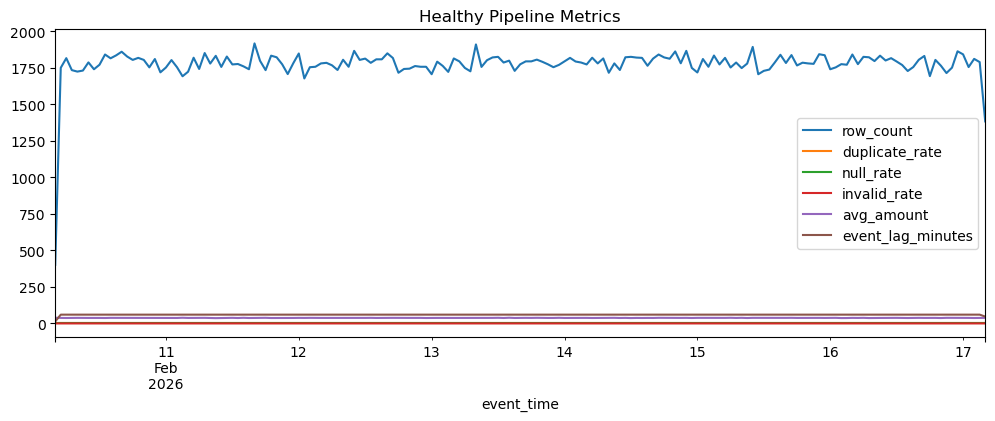

In [8]:
#plotting a healthy pipeline for EDA purposes
pipeline_metrics_healthy.set_index("event_time").plot(
    figsize=(12, 4),
    title="Healthy Pipeline Metrics"
)

In [9]:
#let's now inject failures

#schema changes to add a new column or change amount column to string
transactions_schema_drift = transactions.copy()
transactions_schema_drift["status"] = 'success'

#transactions_schema_drift["amount"] = transactions_schema_drift["amount"].astype(str)

#partial or no ingestion- let's remove 30%
transactions_incomplete = transactions.sample(frac=0.3, random_state=42)

#null explosion -> let's do 45%
transactions_nulls = transactions.copy()
mask = transactions_nulls.sample(frac=0.45, random_state=1).index
transactions_nulls.loc[mask, "amount"] = None

#corrupt with invalid values
transactions_invalid = transactions.copy()
transactions_invalid["amount"] *= 50  # or * -1

#delay data by 3 hours
transactions_stale = transactions.copy()
transactions_stale.index = transactions_stale.index - pd.Timedelta(hours=3)

In [10]:
#merge these datasets
datasets = {
    "healthy": transactions,
    "row_loss": transactions_incomplete,
    "nulls": transactions_nulls,
    "invalid": transactions_invalid,
    "stale": transactions_stale,
    "schema_drift": transactions_schema_drift
}

In [11]:
#function to check the schema
def check_schema(df, expected_schema):
    actual_columns = set(df.columns)
    expected_columns = set(expected_schema.keys())

    missing_columns = expected_columns - actual_columns
    unexpected_columns = actual_columns - expected_columns

    #handling event_time being an index
    if "event_time" in missing_columns:
        if pd.api.types.is_datetime64_any_dtype(df.index):
            missing_columns.remove("event_time")

    schema_drift = (len(missing_columns) > 0 or len(unexpected_columns) > 0)

    return {
        "schema_drift": schema_drift,
        "missing_columns": list(missing_columns),
        "unexpected_columns": list(unexpected_columns),
    }

In [12]:
#function to compute pipeline metrics
def compute_pipeline_metrics(df):
    schema_results = check_schema(df, EXPECTED_SCHEMA)

    return {
        "row_count": len(df),
        "null_rate": df["amount"].isna().mean(),
        "invalid_rate": ((df["amount"] < 0) | (df["amount"] > 100)).mean(),
        "duplicate_rate": df.duplicated().mean(),
        "lag_minutes": (pd.Timestamp.utcnow().tz_localize(None) - df.index.max()).total_seconds() / 60,
        "avg_amount": df["amount"].mean(),
        "schema_drift": schema_results["schema_drift"],
    }

In [13]:
#let's now define pipeline severity
def classify_severity(metrics, healthy_metrics, schema_issues=None):
    severity = []

    #schema check
    if schema_issues and schema_issues.get("schema_drift"):
        severity.append("CRITICAL")
    
    # Row count drop
    if metrics["row_count"] < 0.8 * healthy_metrics["row_count"]:
        severity.append("CRITICAL")

    # Null spike
    if metrics["null_rate"] > 0.2:
        severity.append("CRITICAL")

    # Freshness threshold
    if metrics["lag_minutes"] > 60:
        severity.append("WARNING")

    # Invalid 
    if metrics["invalid_rate"] > 5 * healthy_metrics["invalid_rate"]:
        severity.append("CRITICAL")

    # Avg drift
    if metrics["avg_amount"] > 2 * healthy_metrics["avg_amount"]:
        severity.append("WARNING")

    #dupe check
    if metrics["duplicate_rate"] > 0.02:
        severity.append("WARNING")
    
    if metrics["duplicate_rate"] > 0.15:
        severity.append("CRITICAL")

    if not severity:
        return "INFO"
    elif "CRITICAL" in severity:
        return "CRITICAL"
    elif "WARNING" in severity:
        return "WARNING"

In [14]:
severity_list = []

healthy_metrics = compute_pipeline_metrics(datasets["healthy"])

for name, df in datasets.items():
    schema_issues = check_schema(df, EXPECTED_SCHEMA)
    #print(check_schema(datasets["healthy"], EXPECTED_SCHEMA))
    metric_values = compute_pipeline_metrics(df)
    severity = classify_severity(metric_values, healthy_metrics, schema_issues=schema_issues)
    severity_list.append(severity)


metrics = (
    pd.DataFrame.from_dict(
        {name: compute_pipeline_metrics(df) for name, df in datasets.items()},
        orient="index")
).reset_index().rename(columns={"index": "scenario"})

metrics["rule_based_severity"] = severity_list
metrics

#with this rule based approach, we need to be careful about the thresholds for our metrics we set otherwise we miss subtleties.
#so let's compare with anomaly detection

,scenario,row_count,null_rate,invalid_rate,duplicate_rate,lag_minutes,avg_amount,schema_drift,rule_based_severity
0,healthy,300000,0.00,0.013363,0.0,0.114140,37.541352,False,INFO
1,row_loss,90000,0.00,0.013133,0.0,0.114524,37.472104,False,CRITICAL
2,nulls,300000,0.45,0.007363,0.0,0.115866,37.571497,False,CRITICAL
3,invalid,300000,0.00,1.000000,0.0,0.116966,1877.067605,False,CRITICAL
4,stale,300000,0.00,0.013363,0.0,180.118022,37.541352,False,WARNING
5,schema_drift,300000,0.00,0.013363,0.0,0.119276,37.541352,True,CRITICAL


In [15]:
#let's calculate baseline stats for healthy metrics; 
# Freshness is deterministic (SLA-based), not statistical, so we apply threshold logic instead of z-score anomaly detection
#we're using a tolerance of 20% but in future, it should be dynamic (rolling historical windows?) based on the data -seasonality, etc

ANOMALY_METRICS = [
    "row_count",
    "avg_amount",
    "null_rate",
    "invalid_rate",
    "duplicate_rate",\
]

baseline_stats = {
    metric: {
        "mean": healthy_metrics[metric],
        "std": healthy_metrics[metric] * 0.2 if healthy_metrics[metric] != 0 else 1
    }
    for metric in ANOMALY_METRICS
}

def compute_z_score(value, mean, std):
    if std == 0 or pd.isna(std):
        return 0
    return (value - mean) / std

In [16]:
# Statistical anomaly detection:
# Flags metrics whose deviation exceed ±3 standard deviations from healthy baseline.
def detect_anomalies(metrics, baseline_stats, threshold=3):
    anomalies = {}

    for metric in ANOMALY_METRICS:
        mean = baseline_stats[metric]["mean"]
        std = baseline_stats[metric]["std"]
        z = compute_z_score(metrics[metric], mean, std)

        if metric == "row_count":
            anomalies["row_count_drop"] = z < -threshold
            anomalies["row_count_spike"] = z > threshold
        else:
            anomalies[f"{metric}_anomaly"] = abs(z) > threshold

    return anomalies

In [17]:
# Combine schema validation, rule-based thresholds, and statistical anomaly detection
# to assign severity and generate explainable root cause labels.
def evaluate_pipeline(df, healthy_metrics, baseline_stats, expected_schema):
    schema_results = check_schema(df, expected_schema)

    metrics = compute_pipeline_metrics(df)
    metrics["schema_drift"] = schema_results["schema_drift"]
    # Schema drift is treated as a critical system-level issue
    if metrics["schema_drift"]:
        return {
            "severity": "CRITICAL",
            "reason": "Schema drift detected",
            "root_cause": "Schema drift",
            "metrics": metrics
    }

    severity_rules = classify_severity(metrics, healthy_metrics)

    anomalies = detect_anomalies(metrics, baseline_stats)
    anomaly_triggered = any(anomalies.values())

    if severity_rules == "CRITICAL" or anomaly_triggered:
        severity = "CRITICAL"
    elif severity_rules == "WARNING":
        severity = "WARNING"
    else:
        severity = "INFO"

    root_cause = []
    if metrics["row_count"] < 0.8 * healthy_metrics["row_count"]:
        root_cause.append("Row count drop")
    if metrics["null_rate"] > 0.2:
        root_cause.append("Null spike")
    if metrics["invalid_rate"] > 5 * healthy_metrics["invalid_rate"]:
        root_cause.append("Invalid spike")
    if metrics["lag_minutes"] > 60:
        root_cause.append("Stale data")
    if metrics["avg_amount"] > 2 * healthy_metrics["avg_amount"]:
        root_cause.append("Abnormal average value")
    

    # Include numeric anomaly detection triggers
    for metric, triggered in anomalies.items():
        if triggered and metric not in root_cause:
            root_cause.append(f"Anomaly in {metric}")

    if not root_cause:
        reason = "All metrics normal"
        root_cause = ["No issue"]
    else:
        reason = "Metric evaluation"

    return {
        "severity": severity,
        "reason": reason,
        "root_cause": ", ".join(root_cause),
        "metrics": {**metrics, "schema_drift": schema_results["schema_drift"]}
    }


In [18]:
results = []

for name, df in datasets.items():
    evaluation = evaluate_pipeline(df, healthy_metrics, baseline_stats, EXPECTED_SCHEMA)
    row = {
        "scenario": name,
        **evaluation["metrics"],  # expand metrics directly
        "severity": evaluation["severity"],
        "reason": evaluation["reason"],
        "root_cause": evaluation["root_cause"],
    }

    results.append(row)

metrics_df = pd.DataFrame(results)
metrics_df


,scenario,row_count,null_rate,invalid_rate,duplicate_rate,lag_minutes,avg_amount,schema_drift,severity,reason,root_cause
0,healthy,300000,0.00,0.013363,0.0,0.120900,37.541352,False,INFO,All metrics normal,No issue
1,row_loss,90000,0.00,0.013133,0.0,0.121224,37.472104,False,CRITICAL,Metric evaluation,"Row count drop, Anomaly in row_count_drop"
2,nulls,300000,0.45,0.007363,0.0,0.122333,37.571497,False,CRITICAL,Metric evaluation,Null spike
3,invalid,300000,0.00,1.000000,0.0,0.123759,1877.067605,False,CRITICAL,Metric evaluation,"Invalid spike, Abnormal average value, Anomaly..."
4,stale,300000,0.00,0.013363,0.0,180.125020,37.541352,False,WARNING,Metric evaluation,Stale data
5,schema_drift,300000,0.00,0.013363,0.0,0.126190,37.541352,True,CRITICAL,Schema drift detected,Schema drift


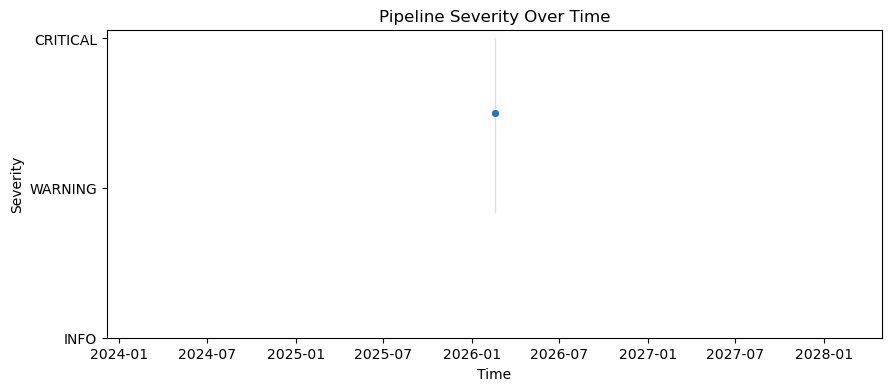

In [19]:
severity_map = {'INFO': 0, 'WARNING': 1, 'CRITICAL': 2}
metrics_df['severity_num'] = metrics_df['severity'].map(severity_map)
metrics_df['timestamp'] = pd.Timestamp.now()

# Plot severity over time
plt.figure(figsize=(10, 4))
sns.lineplot(x='timestamp', y='severity_num', data=metrics_df, marker='o')
plt.yticks([0, 1, 2], ['INFO', 'WARNING', 'CRITICAL'])
plt.title("Pipeline Severity Over Time")
plt.xlabel("Time")
plt.ylabel("Severity")
plt.show()

#Simulate streaming batches and see how severity evolves over time
#Once you simulate streaming or batch updates, each batch will produce a new row of metrics with a timestamp,
#so your plot becomes a continuous line — essentially a real-time monitoring chart.